# Curso: MCC639E

#### Integrantes

- Carlos Tello Tapia
- Lennin Quiso Córdova
- Milton Palacin Grijalva
___

# SEGUNDA PARTE: EXPLORAR CON TÓPIC MODELING

## I. Declaración de librerías

In [1]:
# Tratamiento de datos
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import mglearn

# Tratamiento de texto
# ==============================================================================
from nltk import FreqDist
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

# Visualización Jupyter
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## II. Cargar y explorar el dataset

In [2]:
%%time
dataset_base = pd.read_csv("dataset_base.csv", sep='\t', encoding='utf-8')
dataset_base.sample(5)

CPU times: user 725 ms, sys: 43.8 ms, total: 769 ms
Wall time: 768 ms


,category,title,date,abstract,content,content_for_topic,content_for_summary,abstract_for_summary
3039,DEFENSORIA DEL PUEBLO,RESOLUCION N° 004-2021/DP,15/06/2021,Aprueban el Cuadro para Asignación de Personal...,"Lima, 12 de junio del 2021 VISTO: El Memorand...",lima junio visto memorando ogdh adjuntar ofici...,lima junio visto memorando ogdh adjunta oficio...,aprueban el cuadro para asignación de personal...
3641,INSTITUTO NACIONAL DE ESTADISTICA E INFORMATICA,RESOLUCION JEFATURAL N° 120-2021-INEI,01/06/2021,Aprueban el Índice de Precios al Por Mayor a N...,"Lima, 31 de mayo de 2021 CONSIDERANDO: Que, me...",lima mayo mediante resolución ministerial habe...,lima mayo mediante resolución ministerial disp...,aprueban el índice de precios al por mayor niv...
2722,SALUD,RESOLUCION MINISTERIAL N° 779-2021/MINSA,21/06/2021,Aprueban el Documento Técnico: Lineamientos pa...,"Lima, 21 de junio del 2021 Visto, el expedient...",lima junio visto expediente contener informe d...,lima junio visto expediente contiene informe d...,aprueban el documento técnico lineamientos par...
3030,SUPERINTENDENCIA NACIONAL DE ADUANAS Y DE ADMI...,RESOLUCION N° 000079-2021/SUNAT,15/06/2021,Aprueban el procedimiento específico Aplicació...,APRUEBAN EL PROCEDIMIENTO ESPECÍFICO “APLICACI...,apruer procedimiento específico aplicación pre...,aprueban procedimiento específico aplicación p...,aprueban el procedimiento específico aplicació...
272,MUNICIPALIDAD DE VENTANILLA,DECRETO DE ALCALDIA N° 011-2021/MDV-ALC,13/08/2021,Adecuan el Cuadro de Asignación de Personal CA...,"Ventanilla, 30 de junio de 2021 EL SEÑOR ALCAL...",ventanillo junio señor alcalde municipalidad d...,ventanilla junio señor alcalde municipalidad d...,adecuan el cuadro de asignación de personal ca...


In [3]:
print("Total de normas legales en el dataset:", dataset_base.shape[0])

Total de normas legales en el dataset: 4017


CPU times: user 335 ms, sys: 700 µs, total: 335 ms
Wall time: 330 ms


<AxesSubplot:xlabel='count', ylabel='category'>

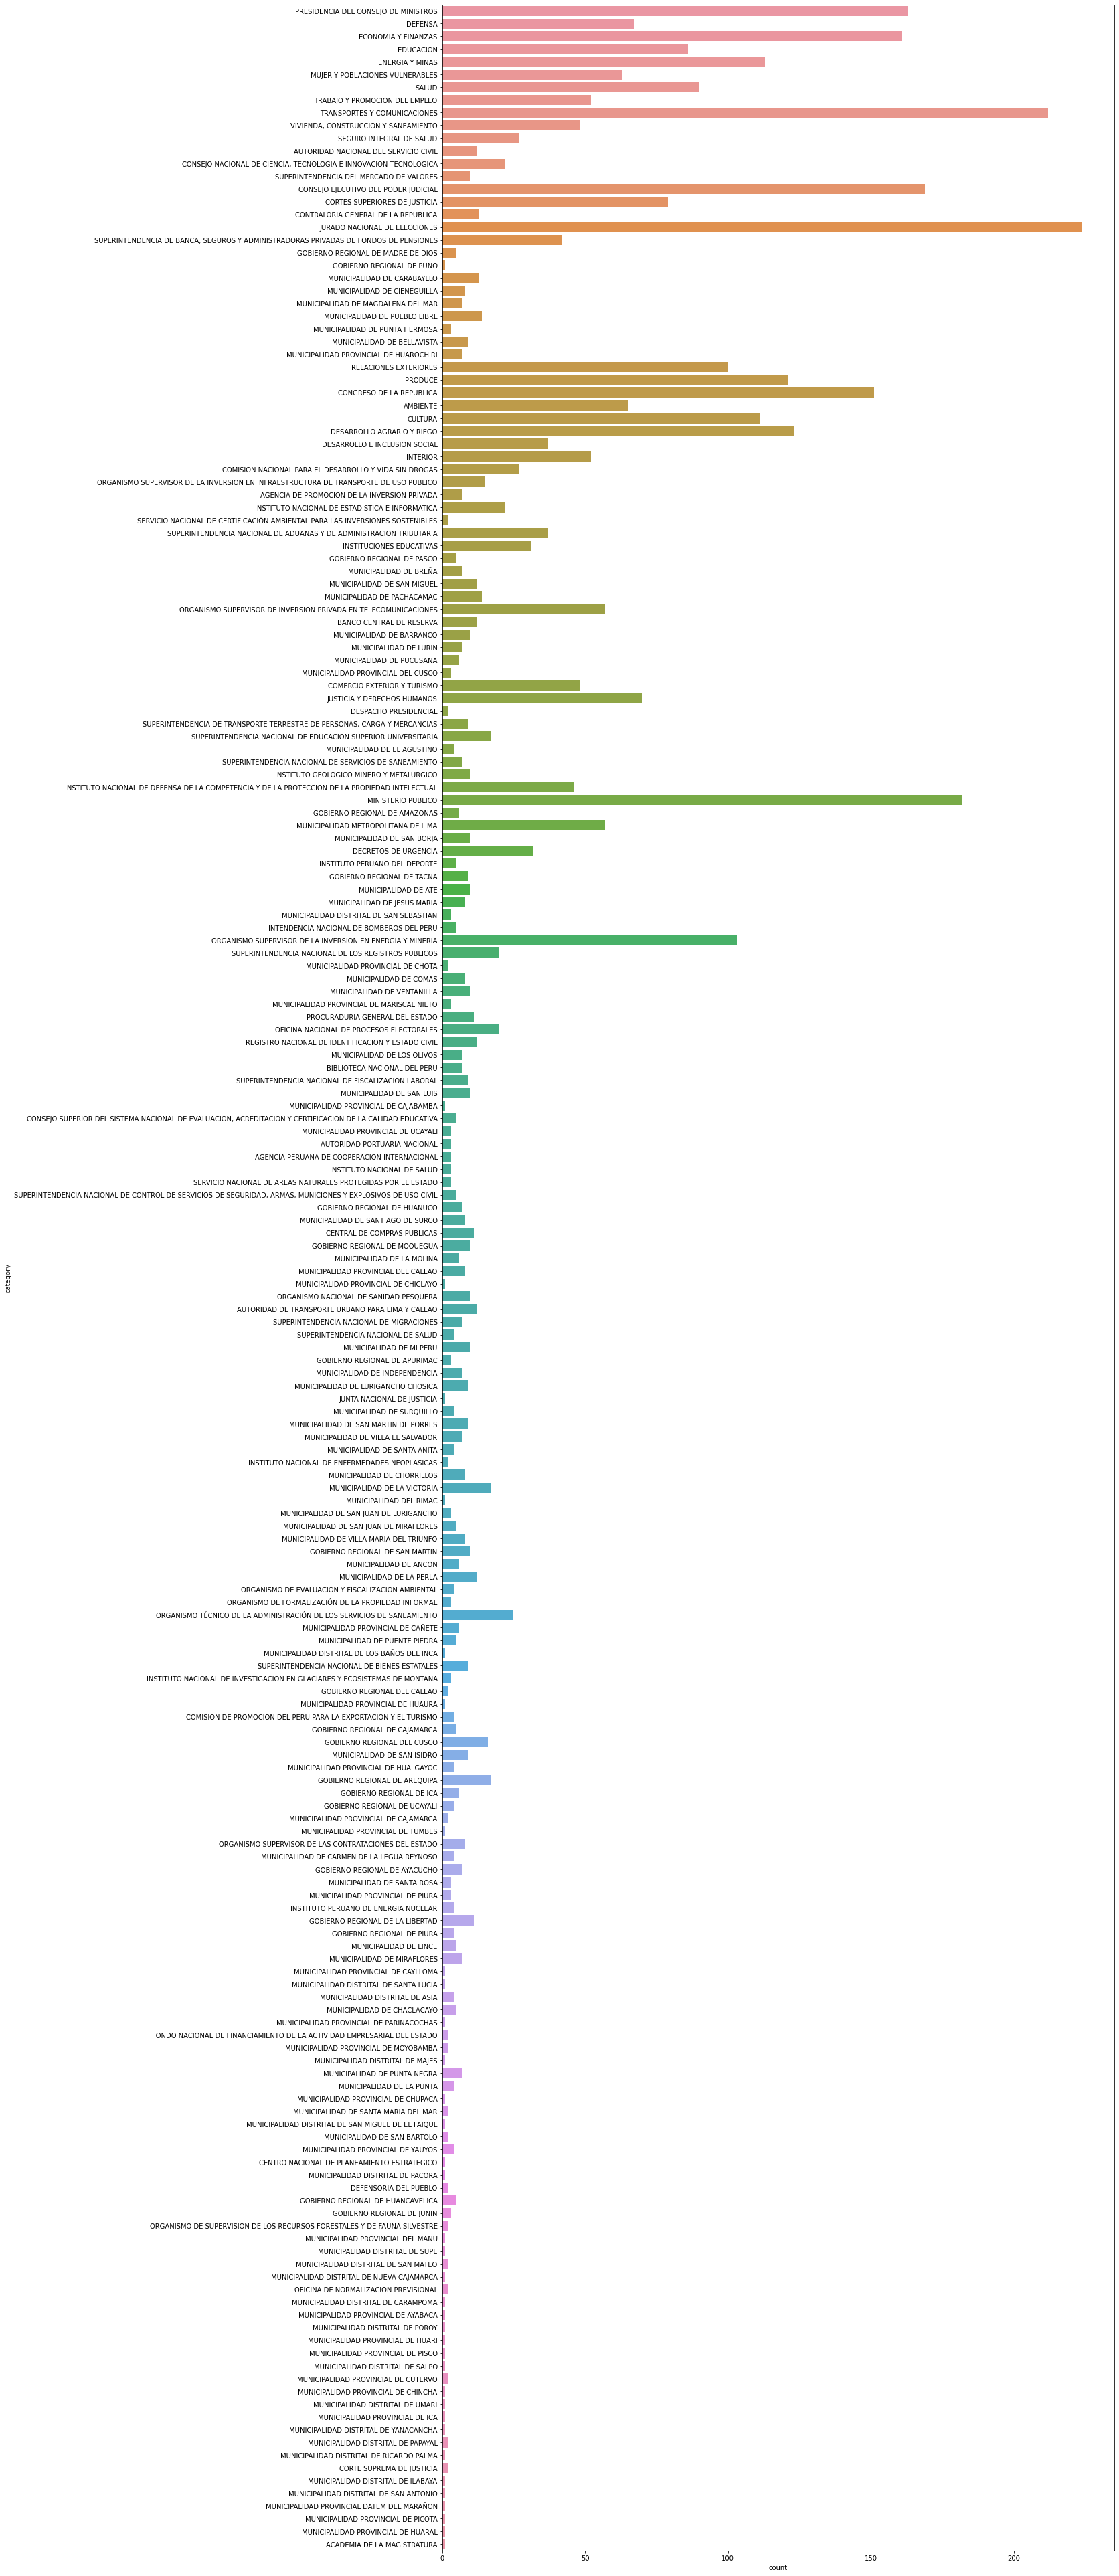

In [4]:
%%time
plt.figure(figsize=(18,70))
sns.countplot(y='category', data=dataset_base, orient='h')

___
Verificacióndel corpus
___

In [5]:
%%time
frec = FreqDist(word_tokenize(' '.join(dataset_base['content_for_topic'])))
frec.most_common(10)

CPU times: user 12.3 s, sys: 48.9 ms, total: 12.3 s
Wall time: 12.4 s


[('resolución', 25560),
 ('decreto', 23970),
 ('nacional', 21374),
 ('general', 20558),
 ('público', 17793),
 ('presente', 16901),
 ('mediante', 16813),
 ('supremo', 15826),
 ('reglamento', 13665),
 ('informe', 13591)]

In [6]:
# Tamaño de arreglo de palabras
print("Total de palabras del vacabulario:", len(frec))
print("Total de palabras que represetn lso tokens:", frec.N())

Total de palabras del vacabulario: 30336
Total de palabras que represetn lso tokens: 2878969


## III. Configurar el dataset para el Topic Modelling

___
Confirgurar y realizar proceso de vectorización/diccionario del contenido
___

In [7]:
%%time

# Representación vectorizada de todo el texto con TF-IDF
tfidf_model = TfidfVectorizer(
    max_df=0.99, # max_df : Frecuencia máxima de documentos para la palabra procesada
    max_features=20000, # max_features: númerp máximo de palabras
    min_df=0.01, # min_df : Frecuencia mínima para la palabra procesada
    use_idf=True, # use_idf: Si es falso solo calcula TF
    ngram_range=(1,1) # ngram_range: (min, max), p.e. (1, 2)incluye 1-gram, 2-gram
)

# Aplicamos el modelo 
tfidf_matrix = tfidf_model.fit_transform(dataset_base.content_for_topic) 

print("="*50)
print("En total hay {} filas (normas legales) y {} terminos.".format(
    str(tfidf_matrix.shape[0]), str(tfidf_matrix.shape[1])
))
print("="*50)

En total hay 4017 filas (normas legales) y 3223 terminos.
CPU times: user 1.5 s, sys: 3.27 ms, total: 1.51 s
Wall time: 1.51 s


___
Realizar validación cruzada para encontrar el mejor número de clusters (Hiperparáemtro).  
Se utiliza Latent Dirichlet Allocation (LDA)
___

In [8]:
%%time

# Prámetros a optimizar
#grid_params = {'n_components': list(range(1,6))}
grid_params = {'n_components': [5, 7, 10], 'learning_decay': [.5, .7, .9]}

# Modelo lda
lda = LatentDirichletAllocation()

#validación cruzada
lda_model = GridSearchCV(lda,param_grid=grid_params, verbose=1, n_jobs=20)
lda_model.fit(tfidf_matrix)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  45 out of  45 | elapsed:  1.4min finished


CPU times: user 10.3 s, sys: 218 ms, total: 10.5 s
Wall time: 1min 32s


GridSearchCV(estimator=LatentDirichletAllocation(), n_jobs=20,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 7, 10]},
             verbose=1)

In [9]:
%%time
lda_model1 = lda_model.best_estimator_
print("Mejores parámetros para el modelo LDA:" , lda_model.best_params_)
print("Mejor puntage de probabilidad logísticas (veracidad) del modelo LDA",lda_model.best_score_)
print("Compljedidad del modelo LDA", lda_model1.perplexity(tfidf_matrix))

Mejores parámetros para el modelo LDA: {'learning_decay': 0.9, 'n_components': 5}
Mejor puntage de probabilidad logísticas (veracidad) del modelo LDA -63450.50059780927
Compljedidad del modelo LDA 2903.6073203221968
CPU times: user 906 ms, sys: 0 ns, total: 906 ms
Wall time: 904 ms


## III. Topic Modelling

___
Ejecutar el modelo con los mejores parámetros (Tópicos y gradiente del Leaning Rate)
___

In [10]:
%%time
n_topics = 5
n_learning_decay=0.9
lda = LatentDirichletAllocation(n_components=n_topics, learning_decay=n_learning_decay, verbose=True).fit(tfidf_matrix)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
CPU times: user 9.51 s, sys: 0 ns, total: 9.51 s
Wall time: 9.5 s


___
Revisar los valores generados los tópicos generados
___

In [11]:
%%time
#  Aplicar la transformación para obtener los datos
lda_data = lda.transform(tfidf_matrix)
lda.components_[0], lda_data.shape

CPU times: user 521 ms, sys: 0 ns, total: 521 ms
Wall time: 520 ms


(array([0.2003643 , 0.20026634, 0.20193402, ..., 0.2022272 , 5.75997725,
        0.35490577]),
 (4017, 5))

___
Revisar el valor de cada fila/registro (norma legal) dentro de cada tópico. 

In [12]:
%%time
# Nombres de columnas
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# Norma legal indexada
doc_names = ["Norma " + str(i) for i in range(tfidf_matrix.shape[0])]

# Crear un dateset los valores del tópico y el registro
df_document_topic = pd.DataFrame(np.round(lda_data, 3), columns=topic_names, index=doc_names)

# Obtener el tópico dominate pro cada registro
topic = np.argmax(df_document_topic.values, axis=1)

df_document_topic['TOPIC'] = topic
df_document_topic.sample(10)

CPU times: user 3.5 ms, sys: 0 ns, total: 3.5 ms
Wall time: 2.82 ms


,Topic0,Topic1,Topic2,Topic3,Topic4,TOPIC
Norma 2478,0.032,0.027,0.891,0.025,0.025,2
Norma 818,0.025,0.901,0.025,0.025,0.025,1
Norma 306,0.024,0.905,0.024,0.024,0.024,1
Norma 298,0.019,0.770,0.118,0.074,0.019,1
Norma 225,0.032,0.032,0.872,0.032,0.032,2
Norma 2370,0.018,0.929,0.018,0.018,0.018,1
Norma 420,0.024,0.900,0.025,0.025,0.026,1
Norma 2066,0.024,0.903,0.024,0.024,0.024,1
Norma 1912,0.024,0.025,0.902,0.025,0.024,2
Norma 3222,0.019,0.020,0.775,0.158,0.028,2


___
Total registros por tópico
___

In [13]:
# Total de registros (normas legales) por tópico
df_document_topic.TOPIC.value_counts().to_frame()

,TOPIC
1,2424
2,960
3,458
0,89
4,86


In [14]:
# Crear dataset de palabras por tópico
df_topic_words01 = pd.DataFrame(lda.components_)

# Datos de columna e índice
df_topic_words01.columns = tfidf_model.get_feature_names()
df_topic_words01.index = topic_names

df_topic_words01

,abandono,abarcar,abastecimiento,abierto,abocar,abogada,abogado,abonar,abordar,abril,...,óptico,óptimo,órden,órgano,óscar,último,única,únicamente,único,útil
Topic0,0.200364,0.200266,0.201934,0.204881,0.200010,0.202800,0.275222,0.309416,0.200579,1.343703,...,0.200543,0.202513,0.200086,0.894716,0.200079,0.201166,1.317685,0.202227,5.759977,0.354906
Topic1,2.499360,1.131964,8.685845,2.657294,0.200001,0.203528,0.226095,0.850984,0.953725,13.419501,...,0.877087,1.208945,1.093731,22.262512,3.703227,10.171446,0.689771,2.817081,28.470931,2.336424
Topic2,0.200515,0.203285,0.708857,0.204200,0.200002,18.204447,20.310594,0.203734,0.200274,7.178171,...,2.801435,0.204654,1.445702,5.156212,0.203046,3.960856,0.200476,1.198165,25.788361,0.204408
Topic3,0.200520,0.214542,0.200486,0.887516,0.678609,2.183775,5.935526,0.742604,0.424994,4.975699,...,0.201197,1.556239,0.311963,12.503549,0.241806,2.536741,0.200172,2.247443,4.366351,0.328122
Topic4,0.201856,0.291156,0.201256,0.238605,0.200010,0.203743,0.224026,0.200891,0.200210,1.119978,...,0.200646,0.202091,0.201466,0.511497,0.202897,0.201839,0.203446,0.202764,0.630333,0.201266


<AxesSubplot:>

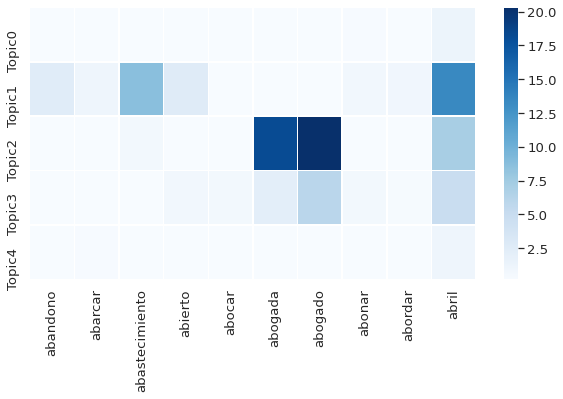

In [15]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.set(font_scale=1.2)
sns.heatmap(
            df_topic_words01.iloc[:,:10],
            linewidth=0.5,
            cmap="Blues",
            annot=False,
            fmt=".2g",
            cbar=True
        )

___
Imprimr las primeras 10 palabras asociadas a cada tópico
___

In [16]:
%%time

# Función para imprimir las 10 principales palabras  por cada tópico
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # Por cada tópico se considera el peso
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=10)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words.T



CPU times: user 4.8 ms, sys: 47 µs, total: 4.85 ms
Wall time: 4.16 ms


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
Word 0,regional,decreto,fiscal,electoral,cultural
Word 1,congreso,resolución,fiscalía,judicial,patrimonio
Word 2,ordenanza,salud,designar,elección,urbano
Word 3,universidad,nacional,cargo,justicia,vivienda
Word 4,esther,general,ministerio,corte,cultura
Word 5,vicepresidente,ministerio,tributario,superior,arqueológico
Word 6,veintiuno,público,provincial,acta,bien
Word 7,andrés,supremo,exterior,juez,nación
Word 8,alvir,presupuesto,designación,juzgado,provisional
Word 9,mirtha,mediante,general,jurado,localidad


In [17]:
df_topic_words01.iloc[:,:5]

,abandono,abarcar,abastecimiento,abierto,abocar
Topic0,0.200364,0.200266,0.201934,0.204881,0.200010
Topic1,2.499360,1.131964,8.685845,2.657294,0.200001
Topic2,0.200515,0.203285,0.708857,0.204200,0.200002
Topic3,0.200520,0.214542,0.200486,0.887516,0.678609
Topic4,0.201856,0.291156,0.201256,0.238605,0.200010
